# Scenario

We consider the wiretap channel with Rayleigh fading.

The secret key capacity is given as
$$C_{s}(X, Y) = \log_2\left(\frac{1 + \alpha X + \beta Y}{1 + \beta Y}\right)$$

The receive signals X and Y are, due to fading, exponentially distributed, i.e., $X\sim\exp(\lambda_{x})$ and $Y\sim\exp(\lambda_{y})$.

# Results

In the following, the upper and lower bound on both the SINR and rate are presented. For comparison, the iid case is also given.
The derivations can be found in $\color{red}{\text{add reference}}$.

In [1]:
import numpy as np
from scipy import integrate
from scipy.special import expi
from scipy import stats
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact

In [2]:
def inv_cdf(u, lam=1):
    return -np.log(1-u)/lam

def capacity(x, y, a=1, b=1):
    return np.log2((1 + a*x + b*y)/(1+b*y))

In [6]:
def independent_capacity(lam_x=1, lam_y=1, a=1, b=1):
    _part1 = np.exp(lam_y/b)*expi(-lam_y/b)
    if lam_x/a == lam_y/b:
        _part2 = (-a + np.exp(lam_x/a)*(a-lam_x)*expi(-lam_x/a))/a
    else:
        _part2 = (a*np.exp(lam_x/a)*lam_y*expi(-lam_x/a)-b*np.exp(lam_y/b)*lam_x*expi(-lam_y/b))/(a*lam_y-b*lam_x)
    return (_part1 - _part2)/np.log(2)

def lower_bound(lam_x=1, lam_y=1, a=1, b=1):
    _part1 = np.exp(lam_y/b)*expi(-lam_y/b)
    _part2 = np.exp((lam_x*lam_y)/(a*lam_y+b*lam_x))*expi(-(lam_x*lam_y)/(a*lam_y+b*lam_x))
    return (_part1 - _part2)/np.log(2)

def upper_bound(lam_x=1, lam_y=1, a=1, b=1):
    def cost_func(u, lam_x=1, lam_y=1, a=1, b=1):
        return capacity(inv_cdf(u, lam=lam_x), inv_cdf(1.-u, lam=lam_y), a=a, b=b)
    expected = integrate.quad(cost_func, 0, 1, args=(lam_x, lam_y, a, b))
    return expected[0]

In [7]:
def calc_expected(snr_db_bob, snr_db_eve, bound='min', lam_x=1, lam_y=1):
    snr_lin_a = 10**(snr_db_bob/10.)
    snr_lin_b = 10**(snr_db_eve/10.)
    if bound == 'iid':
        value = independent_capacity(lam_x=lam_x, lam_y=lam_y, a=snr_lin_a, b=snr_lin_b)
    elif bound == "lower":
        value = lower_bound(lam_x=lam_x, lam_y=lam_y, a=snr_lin_a, b=snr_lin_b)
    elif bound == "upper":
        value = upper_bound(lam_x=lam_x, lam_y=lam_y, a=snr_lin_a, b=snr_lin_b)
    return np.maximum(value, 0)

<IPython.core.display.Javascript object>


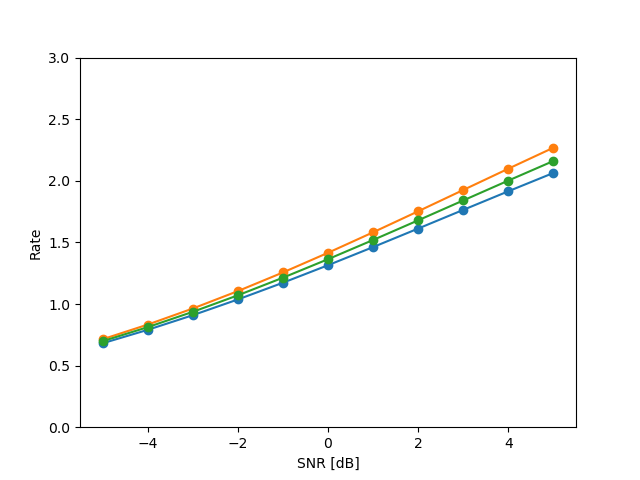

interactive(children=(FloatSlider(value=1.0, description='lam_x', max=3.0, min=0.1), FloatSlider(value=1.0, de…

In [8]:
def capacity_plot():
    fig, ax = plt.subplots(num="Rate")
    ax.set_xlabel("SNR [dB]")
    ax.set_ylabel("Rate")
    ax.set_ylim([0, 3])
    plots = {}
    snr_db = np.arange(-5, 6)
    keys = ['lower', 'upper', 'iid']
    for _key in keys:
        results = [calc_expected(snr, snr, _key) for snr in snr_db]
        plots[_key] = ax.plot(snr_db, results, 'o-')[0]
    
    def update_plot(lam_x=1, lam_y=1):
        for _key, _plot in plots.items():
            _plot.set_ydata([calc_expected(snr, snr, _key, lam_x=lam_x, lam_y=lam_y) for snr in snr_db])
        fig.canvas.draw_idle()
    
    interact(update_plot, lam_x=(.1, 3., .1), lam_y=(.25, 5., .25))

capacity_plot()